In [ ]:
# import sys
# sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
from PIL import Image
import yaml
import pickle
from scipy import stats
import json
from tqdm import tqdm

import pdb

# from dlclive import DLCLive, Processor
from stim_behavior.data_manager import DataManager
from stim_behavior.deeplabcut_manager import DLCManager
from stim_behavior.pelled_octopus.octopus_manager import Driver
from stim_behavior.utils.utils import *
from stim_behavior.utils.helpers import *

In [5]:
# driver = Driver("octopus")

In [25]:
driver = Driver("/home/sachinks/draelos/stim_behavior/configs/octo-17.yaml")

Processing 0 videos from /nfs/turbo/umms-adraelos/sachinks/stim_behavior/sample_videos
	


FileNotFoundError: The pose configuration file for the exported model at /home/sachinks/Code/MyProjects/exported_models/DLC_Octo-Arm_resnet_50_iteration-0_shuffle-1-keypoint17/pose_cfg.yaml was not found. Please check the path to the exported model directory

In [8]:
def process_all_data():
    for video_idx in tqdm(range(len(driver.filenames))):
        ret = driver.load_video(video_idx)
        if not ret:
            continue

        while not driver.is_video_empty():
            ret = driver.read_video()
            if not ret:
                break

            driver.detect_pose()

        driver.release_video()

        driver.save_data(video_idx)

    driver.post_process()

# process_all_data()

In [9]:
# Helper functions

# Load features

def load_features(proSVD=True, verbose=True):
    data_dir = driver.get_data_dir()
    with open(f'{data_dir}/dlc_features.pkl', 'rb') as f:
        df = pickle.load(f)
    df.drop([('features', 'angles'), ('features', 'speed')], axis=1, inplace=True)
    
    if proSVD:
        with open(f'{data_dir}/proSVD_features.pkl', 'rb') as f:
            df_prosvd = pickle.load(f)

        df = pd.merge(df, df_prosvd, on=[('metadata', 'filename')], how='inner')

    if verbose:
        print(df.shape)
        display(df.head(2))
    return df

# Add features

def add_features(df, skeleton_thresh=0.4):
    def add_columns(key, fn):
        new_column_data = df.apply(fn, axis=1)
        ins_pos = df.columns.get_loc(('labels', 'move_class'))
        df.insert(ins_pos, ('features', key), new_column_data)

    def compute_speed(row):
        xy = row[('features', 'xy')]
        return find_speed(xy)

    def compute_skeleton(row):
        xy = row[('features', 'xy')]
        return find_point_point_distance(xy)

    def compute_pred_acc(row):
        skeleton = row[('features', 'skeleton')]
        acc = np.sum(skeleton < skeleton_thresh)/len(skeleton)
        return acc

    add_columns('speed', compute_speed)    
    add_columns('skeleton', compute_skeleton)

    new_column_data = df.apply(compute_pred_acc, axis=1)
    ins_pos = df.columns.get_loc(('labels', 'stim_class'))
    df.insert(ins_pos+1, ('labels', 'pred_acc'), new_column_data)

    return df

In [10]:
# Load & Add

df_features = load_features(proSVD=True, verbose = False)
df_features = add_features(df_features, skeleton_thresh=0.4)
display(df_features.head(2))
for feat in ['xy', 'speed', 'skeleton', 'dQ']:
    print(feat, '\t\t', df_features[('features', feat)][0].shape)

metadata  \
                                      filename   
0  elec_right_cord_100Hz_5mA_220616_131634_000   
1             proximal_pinch_220616_115258_000   

                                            features  \
                                                  xy   
0  [[[396.07852, 200.0402], [387.49155, 203.54031...   
1  [[[393.59735, 199.79143], [387.9191, 203.76796...   

                                                      \
                                                   p   
0  [[0.99997187, 0.99991876, 0.999936, 0.9998191,...   
1  [[0.99996316, 0.9992906, 0.99981815, 0.9999482...   

                                                      \
                                               speed   
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                         labels             \
                                            skeleton move_class stim_class   
0  [0.16959439, 0.16910106, 0.17221986, 0.1695351...          0          0   
1  [0.11659259, 0.11997385, 0.11871561, 0.1105882...          0          5   

                                                     features  
  pred_acc                                                 dQ  
0     1.00  [[0.0, 0.0, 0.0, 0.0], [0.006909703216576469, ...  
1     0.76  [[0.0, 0.0, 0.0, 0.0], [0.011314186517125095, ...

xy 		 (200, 17, 2)
speed 		 (200, 17)
skeleton 		 (200,)
dQ 		 (200, 4)


In [11]:
df_features_slice = df_features[[('features', 'dQ'), ('labels','stim_class')]]

In [12]:
def map_values(value):
    if value in [1, 2]:
        return 1
    elif value in [4, 5]:
        return 4
    else:
        return value

# Applying the function to create the new column
df_features_slice[('labels', 'stim_class_2')] = df_features_slice[('labels', 'stim_class')].apply(map_values)


/home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [35]:
df_features_slice[('features', 'dQ')][0].shape

(200, 4)

In [13]:
df_features_slice.head(2)

features     labels             
                                                  dQ stim_class stim_class_2
0  [[0.0, 0.0, 0.0, 0.0], [0.006909703216576469, ...          0            0
1  [[0.0, 0.0, 0.0, 0.0], [0.011314186517125095, ...          5            4

In [14]:
df_features_slice.groupby([('labels', 'stim_class_2')])

In [15]:
df_features_slice.columns = ['features_dQ', 'stim_class', 'stim_class_2']
df_features_slice.columns

Index(['features_dQ', 'stim_class', 'stim_class_2'], dtype='object')

In [16]:
def mean_of_arrays(arrays):
    # pdb.set_trace()
    return np.mean(np.stack(arrays), axis=0)

# Grouping by the 'labels', 'stim_class_2' column and calculating mean
grouped = df_features_slice.groupby('stim_class_2')['features_dQ'].agg(mean_of_arrays)

In [17]:
tx = np.arange(-20,180)/30

In [18]:
red_palette = sns.color_palette("Reds", n_colors=2)
blue_palette = sns.color_palette("Blues", n_colors=2)
colors = red_palette + blue_palette
colors

[(0.9882352941176471, 0.6261437908496732, 0.5084967320261438),
 (0.8901960784313725, 0.18562091503267975, 0.15294117647058825),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719)]

In [26]:
df_features_slice.head(3)

,features_dQ,stim_class,stim_class_2
0,"[[0.0, 0.0, 0.0, 0.0], [0.006909703216576469, ...",0,0
1,"[[0.0, 0.0, 0.0, 0.0], [0.011314186517125095, ...",5,4
2,"[[0.0, 0.0, 0.0, 0.0], [0.004426496885623101, ...",5,4


In [28]:
df_features_slice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 0 to 146
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   features_dQ   147 non-null    object
 1   stim_class    147 non-null    object
 2   stim_class_2  147 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.7+ KB


In [34]:
df_features_slice['stim_class_2'].value_counts().sort_index()

0    14
1    42
3    18
4    73
Name: stim_class_2, dtype: int64

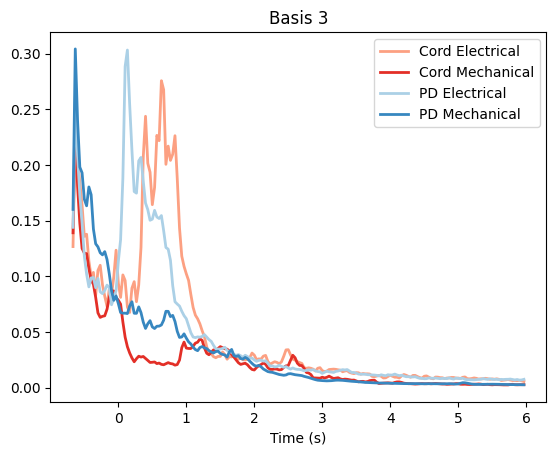

In [90]:
stim_dict = {
    0: 'Cord Electrical',
    1: 'PD Electrical',
    3: 'Cord Mechanical',
    4: 'PD Mechanical'
}
color_dict = {
    0:1,#0
    1:3,#2
    3:1,#1
    4:3#3
}

basis = 3
for i, st in enumerate([0, 3, 1, 4]):
    plt.plot(tx, smooth_data(grouped[st][:, basis], 2), linewidth=2, c=colors[i], label = stim_dict[st])

plt.xlabel("Time (s)")
plt.legend()
plt.title(f"Basis {basis}")
plt.savefig(f"dq_diff_basis_{basis}.svg")

In [118]:
color_map = {
    0:'maroon',#0
    1:'maroon',#2
    3:'darkblue',#1
    4:'darkblue'#3
}

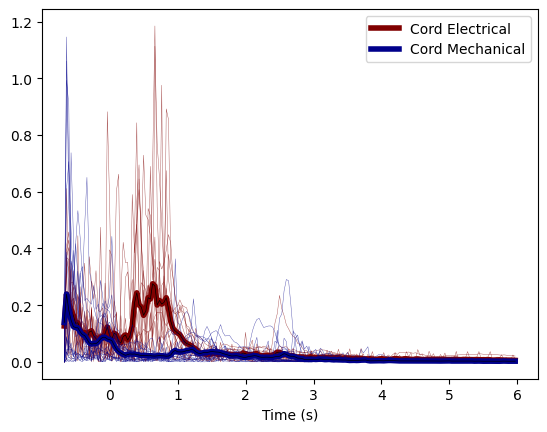

In [124]:
for st in [0, 3]:
    this_one = df_features_slice[df_features_slice['stim_class_2']==st]['features_dQ']

    basis = 3
    that_one = np.stack(this_one.values)[..., basis]

    plt.plot(tx, that_one.T, color=color_map[st], linewidth=0.3, alpha=0.7)
    plt.plot(tx, smooth_data(grouped[st][:, basis], 2), linewidth=4, c=color_map[st], label=stim_dict[st])
    plt.plot(tx, smooth_data(grouped[st][:, basis], 2), linewidth=0.5, c='black')
    plt.xlabel("Time (s)")
    plt.legend()
    plt.savefig(f"dq_diff_cord.svg")

plt.show()

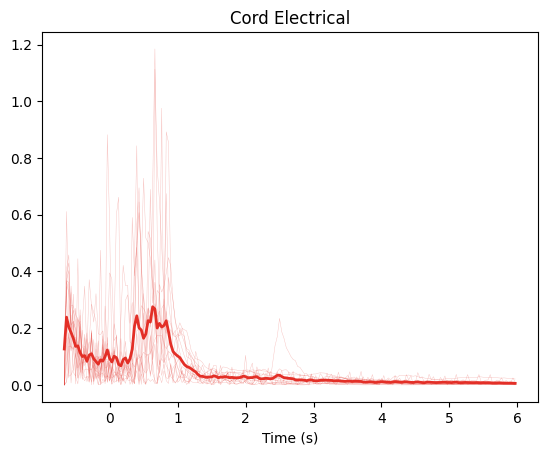

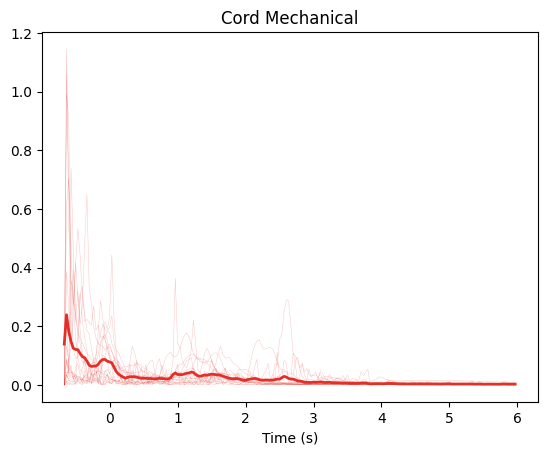

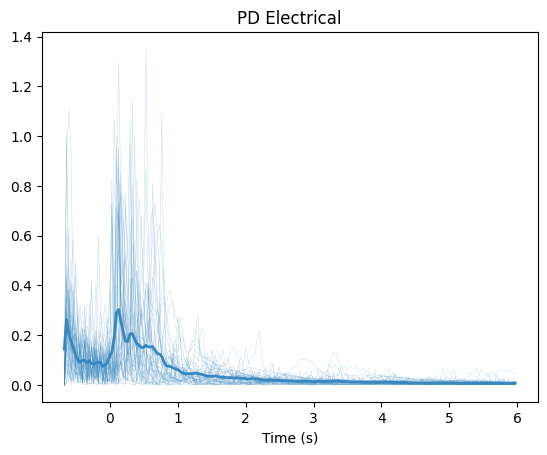

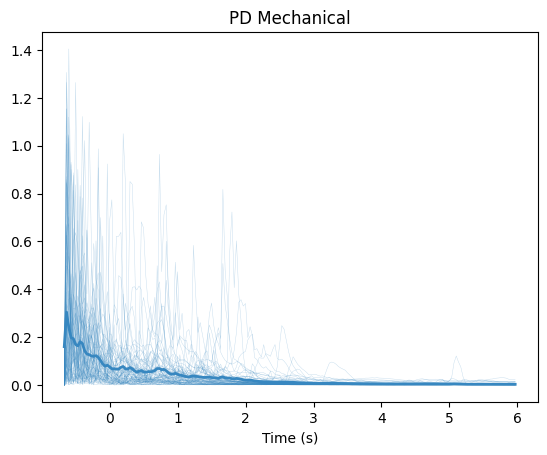

In [89]:
# st = 4 # stimulus
for st in [0, 3, 1, 4]:
    this_one = df_features_slice[df_features_slice['stim_class_2']==st]['features_dQ']

    basis = 3
    that_one = np.stack(this_one.values)[..., basis]

    plt.plot(tx, that_one.T, color=colors[color_dict[st]], linewidth=0.3, alpha=0.3)
    plt.plot(tx, smooth_data(grouped[st][:, basis], 2), linewidth=2, c=colors[color_dict[st]])
    plt.xlabel("Time (s)")
    plt.title(f"{stim_dict[st]}")
    # plt.show()
    plt.savefig(f"dq_diff_{stim_dict[st]}.svg")
    plt.show()

In [91]:
# Extract features

XY = df_features['features', 'xy'].values
proSVD_f = df_features['features', 'dQ'].values
N = len(XY)
mean_angle = np.zeros((N, 3))
max_angle = np.zeros((N, 3))
mean_angular_speed = np.zeros((N, 3))
max_angular_speed = np.zeros((N, 3))
mean_distal_speed = np.zeros((N, 3))
max_distal_speed = np.zeros((N, 3))
total_displacement = np.zeros((N, XY[0].shape[1]))
max_proSVD_dq = np.zeros((N, 3))

## intervals for computing the features
break_intervals = convert_from_seconds_to_frames([
    [0, 1], # 1 second immediately following stimulation
    [1, 2], # 1-2 sec
    [2, None] # > 2 sec
], driver.fps, driver.time_margin)

for i in range(N):
    xy = np.copy(XY[i])
    xy = clean_XY_by_speed(xy)
    # xy = clean_XY_by_point_position(xy)

    distal_speed = find_speed(xy)[:,-1] # speed of distal point
    # distal_speed = np.mean(find_speed(xy), axis=-1)


    feat = np.diff(xy, axis=-2)
    angle_array = np.zeros(feat.shape[0])
    for t in range(feat.shape[0]):
        angle_array[t] = angle_between(feat[t, 0], feat[t, -1])

    # total_displacement[i] = 
    init_pos = np.mean(xy[:30], axis=0)
    final_pos = np.mean(xy[-30:], axis=0)
    total_displacement[i] = np.linalg.norm(final_pos-init_pos, axis=-1)
    L = compute_L(xy).mean()
    total_displacement[i] /= L

    for j, intv in enumerate(break_intervals):
        s, e = intv
        mean_angle[i, j] = np.mean(angle_array[s:e])
        max_angle[i, j] = np.max(angle_array[s:e])
        angular_speed = driver.fps * 1e-3 * np.abs(np.diff(angle_array))
        mean_angular_speed[i, j] = np.mean(angular_speed[s:e])
        max_angular_speed[i, j] = np.percentile(angular_speed[s:e], 95)
        mean_distal_speed[i, j] = np.mean(distal_speed[s:e])
        max_distal_speed[i, j] = np.max(distal_speed[s:e])

        max_proSVD_dq[i, j] = np.max(proSVD_f[i][s:e, 1])

In [17]:
# df_dict = {
#     'filename': [],
#     'move_class': [],
#     'feature(0)': [],
#     'feature(1)': [],
#     'feature(2)': [],
# }
# feature_ = max_distal_speed

# for i in range(N):
#     df_dict['filename'].append(df_features[('metadata', 'filename')].iloc[i])
#     for j in range(feature_.shape[-1]):
#         df_dict[f'feature({j})'].append(feature_[i][j])
#     df_dict['move_class'].append(df_features[('labels', 'move_class')].iloc[i])
# df_dict = pd.DataFrame(df_dict)
# df_dict.head(1)

In [18]:
driver.stim_class_list

['Cord Electrical',
 'Distal Electrical',
 'Proximal Electrical',
 'Cord Mechanical',
 'Distal Mechanical',
 'Proximal Mechanical']

In [92]:
# def add_extra_stim_labels():
# display(df_new_features['label_stim'].value_counts().sort_index())
# display(df_new_features['labelname_stim'].value_counts().sort_values())
# print(driver.stim_class_list)

def remove_duplicates(original_list):
    return list(dict.fromkeys(original_list))

def add_stim_labels(value, type):
    loc, stim = value.split(" ")
    res = ""
    if type == 1:
        if loc in ["Distal", "Proximal"]:
            res += "PD"
        elif loc == "Cord":
            res += "Cord"
        else:
            res += "XXX"
        res += " " + stim
        return res
    elif type == 2:
        if loc in ["Distal", "Proximal"]:
            res += "PD"
        elif loc == "Cord":
            res += "Cord"
        else:
            res += "XXX"
        return res

In [109]:
x = [1,2,3,4,5,6,7]
x[-2:]

[6, 7]

In [110]:
def get_colors(n=6, label=''):
    # Define hues of red and blue
    red_palette = sns.color_palette("Reds", n_colors=3)
    blue_palette = sns.color_palette("Blues", n_colors=3)

    if n%2:
        if label == "MOVE":
            all_colors = blue_palette
        else:
            all_colors = red_palette
    else:
        all_colors = red_palette[-n//2:] + blue_palette[-n//2:]
    return all_colors

def get_label_details(label, type):
    if label == "MOVE":
            label_field = 'label_move'
            label_names = driver.movement_types
    if label == "STIM":
        if type is None:
            label_field = 'label_stim'
            label_names = driver.stim_class_list
        else:
            label_field = f'label_stim_{type}'
            label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
            
    return label_field, label_names
        

In [116]:
plt.rcParams.update({
    # 'font.size': 24,  # Controls default text sizes
    'axes.labelsize': 20,  # X and Y axis label sizes
    'axes.titlesize': 20,  # Title font size
    'xtick.labelsize': 20,  # X-axis tick label size
    'ytick.labelsize': 20,  # Y-axis tick label size
    'legend.fontsize': 16  # Legend font size
})

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),Mean angular speed (2),Max angular speed (2),Mean distal speed (2),Max distal speed (2),Max proSVD feature (2),label_stim,label_move,label_stim_1,label_stim_2
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.021890,0.080982,0.067644,0.222254,0.006254,0.022418,0.062079,Cord Electrical,No movement,Cord Electrical,Cord
1,0.967759,2.792206,0.011637,0.045693,0.134904,0.523930,1.556209,0.008293,0.037744,0.070013,0.254501,0.601273,0.002713,0.007446,0.006150,Proximal Mechanical,No movement,PD Mechanical,PD


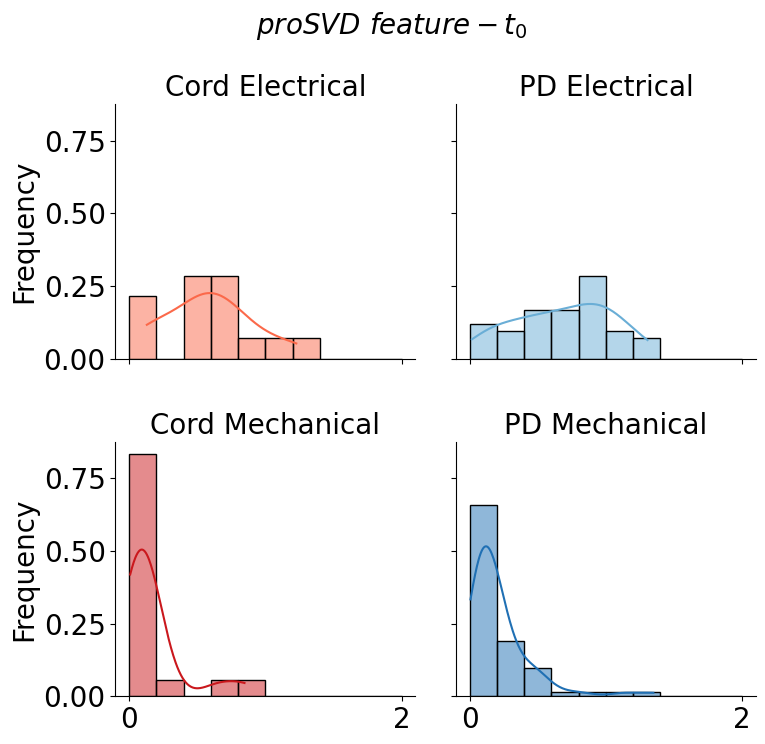

> /tmp/ipykernel_13747/1627317291.py(96)visualize_hist_separate()
     94     for key, value in zip(label_names, all_colors):
     95         pdb.set_trace()
---> 96         hue_mapping[key] = value
     97 
     98     plt.figure(figsize=(6, 5))

['Cord Electrical', 'PD Electrical', 'Cord Mechanical', 'PD Mechanical']
['Cord Electrical', 'PD Electrical', 'Cord Mechanical', 'PD Mechanical']


BdbQuit: 

In [126]:
# Plot visualization

def load_feature_df():
    df_dict = {}
    for i in range(3):
        df_dict[f'Mean angular speed ({i})'] = mean_angular_speed[:, i]
        df_dict[f'Max angular speed ({i})'] = max_angular_speed[:, i]
        df_dict[f'Mean distal speed ({i})'] = mean_distal_speed[:, i]
        df_dict[f'Max distal speed ({i})'] = max_distal_speed[:, i]
        df_dict[f'Max proSVD feature ({i})'] = max_proSVD_dq[:, i]

    # for i in range(total_displacement.shape[-1]):
    #     df_dict[f'Total displacement ({i})'] = total_displacement[:, i]

    df = pd.DataFrame(df_dict)

    label_names = driver.stim_class_list
    df['label'] = df_features['labels', 'stim_class']
    df['label_stim'] = df.apply(lambda row: label_names[row['label']], axis=1)
    df.drop('label', axis=1, inplace=True) 

    label_names = driver.movement_types
    df['label'] = df_features['labels', 'move_class']
    df['label_move'] = df.apply(lambda row: label_names[row['label']], axis=1)
    df.drop('label', axis=1, inplace=True)

    max_type = 2
    for type in range(1, max_type+1):
        label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
        df[f'label_stim_{type}'] = df['label_stim'].apply(lambda row: add_stim_labels(row, type))
    return df

def visualize_hist_separate(df, feature_name, t_i, label="STIM", type=None):
    feature = f'{feature_name} ({t_i})'
    plot_title = r'$proSVD\ feature - t_0$'
    # Set up Seaborn style
    # sns.set(style="white")

    # Calculate bin edges
    mini, maxi = np.floor(df[feature].min()), np.ceil(df[feature].max())
    if maxi - mini == 1: maxi = 0.1*np.round(10*df[feature].max())
    bin_width = 0.1 * (maxi-mini)  # Adjust as needed
    bin_edges = np.arange(mini, maxi + bin_width, bin_width)
    x_labels = np.linspace(mini, maxi, 2)

    if label == "MOVE":
            label_names = driver.movement_types
            label_field = 'label_move'
    if label == "STIM":
        if type is None:
            label_names = driver.stim_class_list
            label_field = 'label_stim'
        else:
            label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
            label_field = f'label_stim_{type}'
    
    label_field, label_names = get_label_details(label, type)
    class_size = len(label_names)
    all_colors = get_colors(class_size, label)

    all_colors = [all_colors[0],all_colors[2],all_colors[1],all_colors[3]]

    # Create a FacetGrid with histograms for each label
    col_wrap = class_size//2 if class_size>3 else class_size
    g = sns.FacetGrid(df, col=label_field, col_wrap=col_wrap, height=4, sharex=True)

    # plt.figure(figsize=(12, 6))
    # Iterate through subplots to set x-axis ticks and labels
    for i, ax in enumerate(g.axes.flat):
        label_value = label_names[i]
        df_ = df[df[label_field] == label_value]
        # pdb.set_trace()
        sns.histplot(data=df_, x=feature, stat="probability", kde=True, bins=bin_edges, ax=ax, color=all_colors[i], common_norm=False)

        ax.set_xticks(x_labels)
        # ax.set_yticks([0, 0.5])
        ax.set_title(df_[label_field].iloc[0], fontsize=20)

    # Set axis labels
    g.set_axis_labels("", "Frequency")

    unit = find_unit(feature)
    if unit is not '': unit = f" ({unit})"
    plt.suptitle(plot_title, y=0.95, fontsize=20)
    # plt.subplots_adjust(hspace=0.2) 
    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.savefig("prosvd_1.svg", bbox_inches='tight')
    plt.show()

    hue_mapping = {}
    for key, value in zip(label_names, all_colors):
        hue_mapping[key] = value

    plt.figure(figsize=(6, 5))
    sns.kdeplot(data=df, x=feature, common_norm=False, hue=label_field, palette=hue_mapping, linewidth=4)

    # Add title and labels
    # plt.xlabel(f"{feature}{unit}")
    plt.xlabel(plot_title, labelpad=-15, fontsize=24)
    plt.ylabel('Frequency')
    plt.xlim(mini, maxi)
    plt.xticks(x_labels)
    plt.yticks([])
    plt.gca().get_legend().set_title('')
    plt.tight_layout()

    plt.savefig("prosvd_2.svg", bbox_inches='tight')
    # Show the plot
    plt.show()

df_new_features = load_feature_df()
display(df_new_features.head(2))
T = 0
feature_name = 'Max proSVD feature'
stim_type = 1
visualize_hist_separate(df_new_features, feature_name, T, "STIM", type=stim_type)



In [12]:
# KS-test main
# locations = ['Cord', 'Distal', 'Proximal']
# stimulations = ['Electrical', 'Mechanical']


all_columns = df_new_features.columns.to_list()
featr_list = [s for s in all_columns if not s.startswith("label")]
label_list = [s for s in all_columns if s.startswith("label")]
label_field = label_list[-1]
label_names = df_new_features[label_field].unique().tolist()

column_name = "PD v/s Cord"

res2 = {}

for featr in featr_list:
    res = {}
    res2[featr] = []


    data = []

    for label_name in label_names:
        data_ = df_new_features.query(f'{label_field} == "{label_name}"')
        data.append(data_[featr])
    data1, data2 = data

    ks_statistic, p_value = stats.ks_2samp(data1, data2)
    
    # Interpret the results
    alpha = 0.05  # Set your desired significance level

    res_string = ''

    if p_value < alpha:
        res_string = 'different'
    else:
        res_string = 'same'

    res[column_name] = [f'{p_value:.2f}', res_string]
    res2[featr].append(f'{res_string}-{p_value:.3f}')
    # print(featr)
    # display(pd.DataFrame(res, index=['p-value', 'distribution']))
    # print()

df_frame = pd.DataFrame(res2).T

def color_text(val):
    if val.startswith('different'):
        color = 'color: green'
    else:
        color = ''
    return f'{color}'

df_frame.columns = [column_name]
df_frame = df_frame.style.applymap(color_text, subset=[column_name])

print("K-S test p-value comparing Elec & Mech")
display(df_frame)

K-S test p-value comparing Elec & Mech


,PD v/s Cord
Mean angular speed (0),different-0.010
Max angular speed (0),different-0.014
Mean distal speed (0),same-0.257
Max distal speed (0),different-0.016
Max proSVD feature (0),same-0.753
Mean angular speed (1),different-0.001
Max angular speed (1),different-0.001
Mean distal speed (1),different-0.029
Max distal speed (1),different-0.012
Max proSVD feature (1),same-0.107


In [132]:
# KS-test 1
locations = ['Cord', 'Distal', 'Proximal']
stimulations = ['Electrical', 'Mechanical']


all_columns = df_new_features.columns.to_list()
featr_list = [s for s in all_columns if not s.startswith("label")]
label_list = [s for s in all_columns if s.startswith("label")]


res2 = {}

for featr in featr_list:
    res = {}
    res2[featr] = []

    for loc in locations:
        data = []
        
        for stim in stimulations:
            label_name = f'{loc} {stim}'
            data_ = df_new_features.query(f'label_stim == "{label_name}"')
            data.append(data_[featr])
        data1, data2 = data

        ks_statistic, p_value = stats.ks_2samp(data1, data2)
        
        # Interpret the results
        alpha = 0.05  # Set your desired significance level

        res_string = ''

        if p_value < alpha:
            res_string = 'different'
        else:
            res_string = 'same'

        res[loc] = [f'{p_value:.3f}', res_string]
        res2[featr].append(f'{res_string}-{p_value:.3f}')
    # print(featr)
    # display(pd.DataFrame(res, index=['p-value', 'distribution']))
    # print()

df_frame = pd.DataFrame(res2).T
df_frame.columns = locations
print("K-S test p-value comparing Elec & Mech")
display(df_frame)

K-S test p-value comparing Elec & Mech


,Cord,Distal,Proximal
Mean angular speed (0),same-0.331,same-0.606,same-0.612
Max angular speed (0),same-0.090,different-0.048,same-0.351
Mean distal speed (0),different-0.017,same-0.268,same-0.176
Max distal speed (0),different-0.014,same-0.078,different-0.029
Max proSVD feature (0),different-0.001,different-0.000,different-0.000
Mean angular speed (1),same-0.071,same-0.840,different-0.001
Max angular speed (1),same-0.071,same-0.998,same-0.088
Mean distal speed (1),different-0.018,same-0.062,different-0.014
Max distal speed (1),same-0.110,different-0.032,same-0.056
Max proSVD feature (1),different-0.043,same-0.083,same-0.711


In [130]:
# KS-test 2
locations1 = ['Cord', 'Distal', 'Proximal']
locations2 = locations[1:] + [locations[0]]

stims = ['Electrical', 'Mechanical']

featr_list = df_new_features.columns.to_list()[:-2]

res2 = {}

for featr in featr_list:
    res = {}
    res2[featr] = []

    for loc1, loc2 in zip(locations1, locations2):
        data = []

        stims_ = [f'{loc1} {stims[0]}', f'{loc1} {stims[1]}']
        data1 = df_new_features.query(f'label_stim in ["{stims_[0]}", "{stims_[1]}"]')[featr]


        stims_ = [f'{loc2} {stims[0]}', f'{loc2} {stims[1]}']
        data2 = df_new_features.query(f'label_stim in ["{stims_[0]}", "{stims_[1]}"]')[featr]

        ks_statistic, p_value = stats.ks_2samp(data1, data2)

        alpha = 0.05  # Set your desired significance level

        res_string = ''

        if p_value < alpha:
            res_string = 'different'
        else:
            res_string = 'same'

        res[f'{loc1} v/s {loc2}'] = [f'{p_value:.2f}', res_string]
        res2[featr].append(f'{res_string}-{p_value:.2f}')

df_frame = pd.DataFrame(res2).T

df_frame.columns = [f'{loc1} v/s {loc2}' for loc1, loc2 in zip(locations1, locations2)]
print("K-S test p-value comparing stimulus locations")
display(df_frame)

K-S test p-value comparing stimulus locations


,Cord v/s Distal,Distal v/s Proximal,Proximal v/s Cord
Mean angular speed (0),different-0.02,same-0.34,different-0.05
Max angular speed (0),different-0.01,same-0.27,same-0.08
Mean distal speed (0),different-0.02,different-0.00,same-0.95
Max distal speed (0),different-0.00,different-0.00,same-0.61
Max proSVD feature (0),same-0.72,same-0.58,same-0.86
Mean angular speed (1),different-0.00,same-0.69,different-0.01
Max angular speed (1),different-0.00,same-0.83,different-0.01
Mean distal speed (1),different-0.04,same-0.89,same-0.10
Max distal speed (1),different-0.02,same-0.81,different-0.01
Max proSVD feature (1),same-0.16,same-0.92,same-0.19


In [15]:
features_list = df_new_features.columns.to_list()
print(features_list)
features_to_compare = [
    [features_list[0], features_list[1]],
    [features_list[2], features_list[3]],
    [features_list[0], features_list[2]],
    [features_list[1], features_list[3]]
]
print(features_to_compare)

['Mean angular speed (0)', 'Max angular speed (0)', 'Mean distal speed (0)', 'Max distal speed (0)', 'Max proSVD feature (0)', 'Mean angular speed (1)', 'Max angular speed (1)', 'Mean distal speed (1)', 'Max distal speed (1)', 'Max proSVD feature (1)', 'Mean angular speed (2)', 'Max angular speed (2)', 'Mean distal speed (2)', 'Max distal speed (2)', 'Max proSVD feature (2)', 'label_stim', 'label_move', 'label_stim_1', 'label_stim_2']
[['Mean angular speed (0)', 'Max angular speed (0)'], ['Mean distal speed (0)', 'Max distal speed (0)'], ['Mean angular speed (0)', 'Mean distal speed (0)'], ['Max angular speed (0)', 'Max distal speed (0)']]


In [31]:
from scipy.stats import multivariate_normal

display(df_new_features.head(1))
red_palette = sns.color_palette("Reds", n_colors=3)
blue_palette = sns.color_palette("Blues", n_colors=3)
all_colors = red_palette + blue_palette

feat1, feat2 = 'Max angular speed (0)', 'Max distal speed (0)'

df = df_new_features

df[f'{feat1}_normed'] = (df[feat1] - df[feat1].mean()) / df[feat1].std()
df[f'{feat2}_normed'] = (df[feat2] - df[feat2].mean()) / df[feat2].std()

sns.scatterplot(x=f'{feat1}_normed', y=f'{feat2}_normed',
                 hue='label_name', palette=all_colors,
                  legend=False, data=df_new_features)
# print(df[[feat1, feat2]].mean())

for i, label in enumerate(driver.stim_class_list):
    subset = df[df['label_name'] == label][[f'{feat1}_normed', f'{feat2}_normed']]
    
    # Fit 2D Gaussian
    mean = subset.mean()
    cov_matrix = np.cov(subset.values.T)
    mvn = multivariate_normal(mean=mean, cov=cov_matrix)
    
    # Generate points for the ellipse
    angle = np.degrees(np.arctan2(*cov_matrix[::-1, :][0]))
    width, height = np.sqrt(5.991 * cov_matrix.diagonal())
    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle, color=all_colors[i], alpha=0.2)
    ellipse2 = plt.matplotlib.patches.Ellipse(mean, width, height, angle, fill=False, edgecolor=all_colors[i], linewidth=2)
    # Plot the ellipse
    plt.gca().add_patch(ellipse)
    plt.gca().add_patch(ellipse2)

# Add labels and title
plt.xlabel(feat1 + ' normalized')
plt.ylabel(feat2 + ' normalized')

# Show the plot
plt.show()

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),Mean angular speed (2),Max angular speed (2),Mean distal speed (2),Max distal speed (2),Max proSVD feature (2),label_stim,label_move,label_stim_1,label_stim_2
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.02189,0.080982,0.067644,0.222254,0.006254,0.022418,0.062079,Cord Electrical,No movement,Cord Electrical,Cord


ValueError: Could not interpret value `label_name` for parameter `hue`

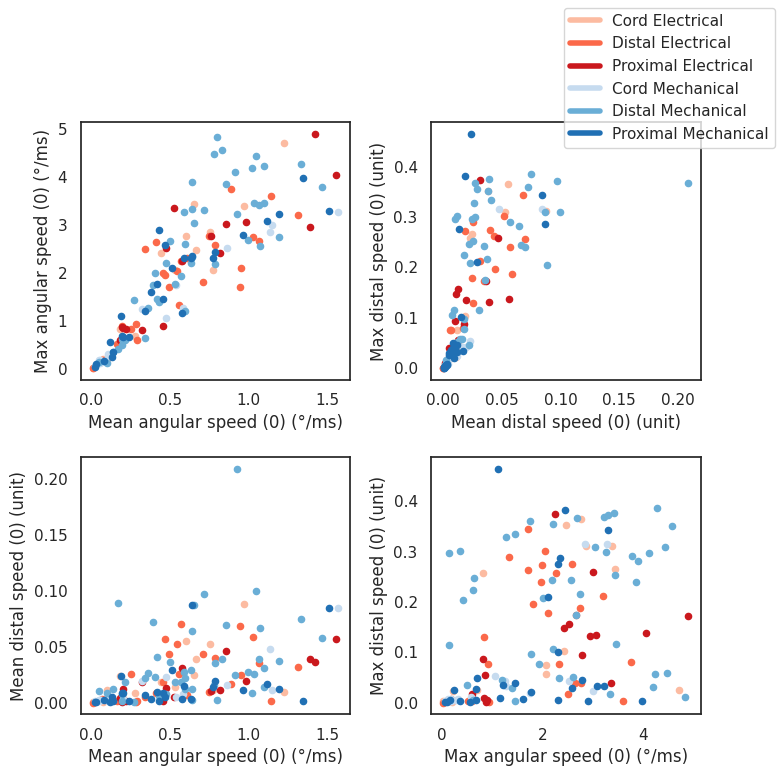

In [39]:
# Electrical Stimulations - Movement

num_rows, num_cols = 2, 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 8), gridspec_kw={'top': 0.85})

class_list = driver.stim_class_list
no_of_points = len(class_list)

red_palette = sns.color_palette("Reds", n_colors=3)
blue_palette = sns.color_palette("Blues", n_colors=3)

# Combine the palettes
if LABEL == "STIM":
    all_colors = red_palette + blue_palette
elif LABEL == "MOVE":
    all_colors = blue_palette

for c in range(no_of_points):
    class_data = df_new_features.query(f'label == {c}')
    for i in range(num_rows):
        for j in range(num_cols):
            k = i*num_cols + j
            to_compare = features_to_compare[k]
            x_lb, y_lb = to_compare
            axs[i, j].scatter(class_data[x_lb], class_data[y_lb],
                color=all_colors[c], label=class_list[c], s=20)
            
            axs[i, j].set_xlabel(f'{x_lb} ({find_unit(x_lb)})')
            axs[i, j].set_ylabel(f'{y_lb} ({find_unit(y_lb)})')

legend_elements = [Line2D([0], [0], color=all_colors[i], lw=4, label=class_list[i]) for i in range(no_of_points)]
fig.legend(title="", handles=legend_elements, loc='upper right')
fig.suptitle(f'')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [56]:
display(df_features['labels', 'move_class'].value_counts().sort_index().to_frame())
display(df_features['labels', 'stim_class'].value_counts().sort_index().to_frame())
print('0.Cord 1.Distal 2.Proximal')

,labels
,move_class
0,38
1,29
2,24


,labels
,stim_class
0,18
1,45
2,28


0.Cord 1.Distal 2.Proximal


In [25]:
df_new_features.iloc[0:5, :15]

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),Mean angular speed (2),Max angular speed (2),Mean distal speed (2),Max distal speed (2),Max proSVD feature (2)
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.021890,0.080982,0.067644,0.222254,0.006254,0.022418,0.062079
1,0.967759,2.792206,0.011637,0.045693,0.134904,0.523930,1.556209,0.008293,0.037744,0.070013,0.254501,0.601273,0.002713,0.007446,0.006150
2,0.576941,1.165109,0.003367,0.008467,0.055274,0.510291,1.236517,0.005897,0.023137,0.045995,0.313744,1.358045,0.005899,0.078301,0.088322
3,0.634982,2.202688,0.028817,0.355622,0.234853,0.063785,0.181178,0.002104,0.007536,0.022021,0.110341,0.265777,0.002500,0.008447,0.008395
4,0.206872,0.864558,0.012481,0.055214,0.251123,1.059839,4.238542,0.080122,0.362997,0.087211,0.494337,1.307884,0.019222,0.323104,0.032052


In [119]:
print(pca.components_.shape)
print(data.shape)
# display(pca.components_)
print(data.columns.tolist())

(32, 32)
(147, 32)
['Mean angular speed (0)', 'Max angular speed (0)', 'Mean distal speed (0)', 'Max distal speed (0)', 'Max proSVD feature (0)', 'Mean angular speed (1)', 'Max angular speed (1)', 'Mean distal speed (1)', 'Max distal speed (1)', 'Max proSVD feature (1)', 'Mean angular speed (2)', 'Max angular speed (2)', 'Mean distal speed (2)', 'Max distal speed (2)', 'Max proSVD feature (2)', 'Total displacement (0)', 'Total displacement (1)', 'Total displacement (2)', 'Total displacement (3)', 'Total displacement (4)', 'Total displacement (5)', 'Total displacement (6)', 'Total displacement (7)', 'Total displacement (8)', 'Total displacement (9)', 'Total displacement (10)', 'Total displacement (11)', 'Total displacement (12)', 'Total displacement (13)', 'Total displacement (14)', 'Total displacement (15)', 'Total displacement (16)']


In [23]:
plt.rcParams.update({
    'font.size': 20,  # Controls default text sizes
    'axes.labelsize': 18,  # X and Y axis label sizes
    'axes.titlesize': 18,  # Title font size
    'xtick.labelsize': 14,  # X-axis tick label size
    'ytick.labelsize': 14,  # Y-axis tick label size
    'legend.fontsize': 20  # Legend font size
})

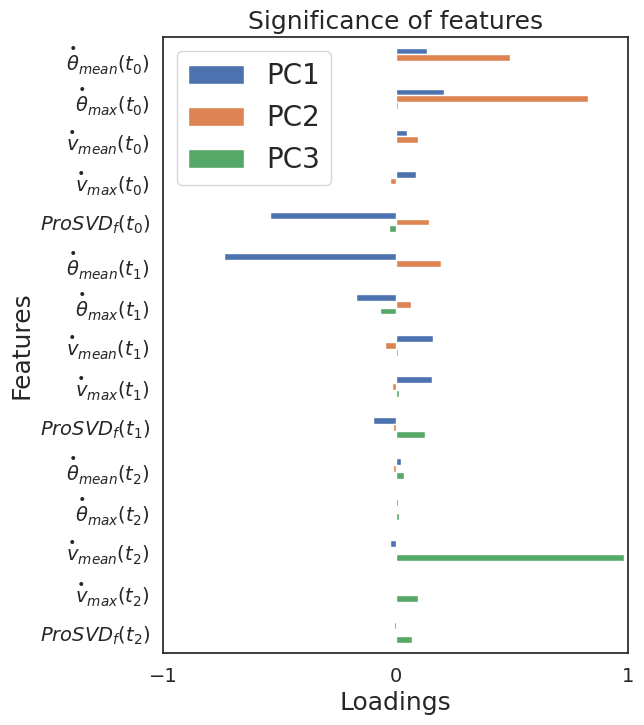

In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate some example data
np.random.seed(0)
data = df_new_features.select_dtypes(include='float64')

# Perform PCA
pca = PCA()
pca.fit(data)

# Access the loadings for the first two principal components for the three most important features
n_features_to_plot = 15
loadings_for_plot = pca.components_[:n_features_to_plot, :3]

# Create a DataFrame to display the loadings
features = data.columns.tolist()[:n_features_to_plot]
features = [
    r'$\overset{\bullet}{\theta}_{mean}(t_0)$',
    r'$\overset{\bullet}{\theta}_{max}(t_0)$',
    r'$\overset{\bullet}{v}_{mean}(t_0)$',
    r'$\overset{\bullet}{v}_{max}(t_0)$',
    r'$ProSVD_f(t_0)$',
    r'$\overset{\bullet}{\theta}_{mean}(t_1)$',
    r'$\overset{\bullet}{\theta}_{max}(t_1)$',
    r'$\overset{\bullet}{v}_{mean}(t_1)$',
    r'$\overset{\bullet}{v}_{max}(t_1)$',
    r'$ProSVD_f(t_1)$',
    r'$\overset{\bullet}{\theta}_{mean}(t_2)$',
    r'$\overset{\bullet}{\theta}_{max}(t_2)$',
    r'$\overset{\bullet}{v}_{mean}(t_2)$',
    r'$\overset{\bullet}{v}_{max}(t_2)$',
    r'$ProSVD_f(t_2)$',
]
loadings_df = pd.DataFrame(loadings_for_plot, columns=['PC1', 'PC2', 'PC3'], index=features)

# Plot the loadings as a bar chart
ax = loadings_df.plot(kind='barh', figsize=(6, 8))
ax.invert_yaxis()
plt.xlabel('Loadings')
plt.ylabel('Features')
plt.title('Significance of features')
plt.xticks([-1, 0, 1], rotation=0)
plt.xlim([-1,1])
plt.savefig("x.svg", bbox_inches='tight')
# plt.show()


In [96]:
data=np.vstack([loadings[0, top_features_pc1], loadings[1, top_features_pc2]])
data

array([[ 0.5063108 ,  0.51154917,  0.54648931],
       [-0.41011012,  0.47386964, -0.6498715 ]])

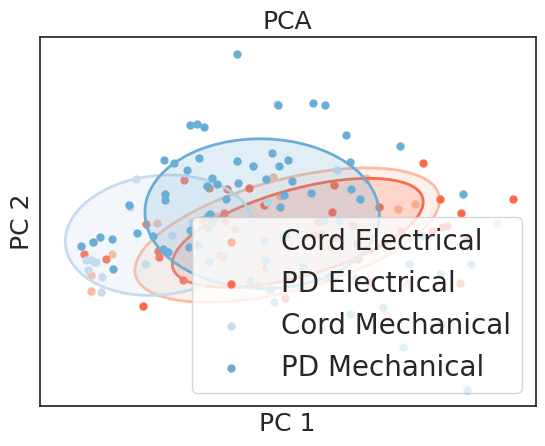

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new_features = load_feature_df()

data = df_new_features.select_dtypes(include='float64')


label_class = "STIM"
label_field, label_names = get_label_details(label_class, 1)
all_colors = get_colors(len(label_names), label_class)

data_labels = df_new_features[label_field].to_frame()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA() #(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


# no_of_points = len(label_names)

for c, label in enumerate(label_names):
    indices = data_labels.query(f"{label_field} == '{label}'").index
    subset = reduced_data[indices][:, :2]
    plt.scatter(subset[:, 0], subset[:, 1],
                color=all_colors[c], label=label, s=25)

    # Fit 2D Gaussian
    mean = subset.mean(axis=0)
    cov_matrix = np.cov(subset.T)
    mvn = multivariate_normal(mean=mean, cov=cov_matrix)
    
    # Generate points for the ellipse
    angle = np.degrees(np.arctan2(*cov_matrix[::-1, :][0]))
    width, height = np.sqrt(5.991 * cov_matrix.diagonal())
    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle, color=all_colors[c], alpha=0.2)
    ellipse2 = plt.matplotlib.patches.Ellipse(mean, width, height, angle, fill=False, edgecolor=all_colors[c], linewidth=2)
    # Plot the ellipse
    plt.gca().add_patch(ellipse)
    plt.gca().add_patch(ellipse2)
            
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title(f'PCA')
plt.show()

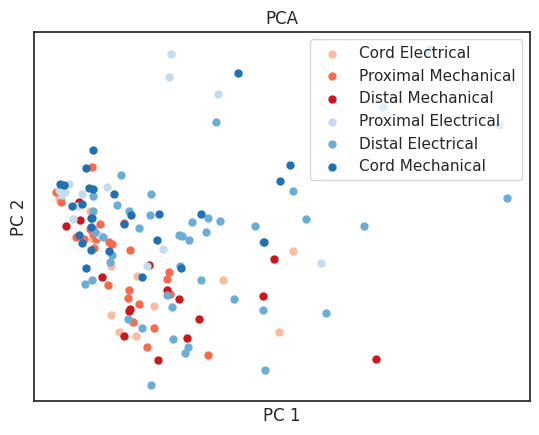

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new_features = load_feature_df("STIM")

data, data_labels = df_new_features.iloc[:, :-2], df_new_features.iloc[:, -2:-1]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA() #(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


class_list = df_new_features['label_name'].unique().tolist()
no_of_points = len(class_list)

for c in range(no_of_points):
    indices = data_labels.query(f'label == {c}').index
    class_data = reduced_data[indices]
    plt.scatter(class_data[:, 0], class_data[:, 1],
                color=all_colors[c], label=class_list[c], s=25)
            
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title(f'PCA')
plt.show()

In [84]:
df_new_features['reduced_data'].head(2)

0   -3.576097
1   -1.111298
Name: reduced_data, dtype: float64

(147,)


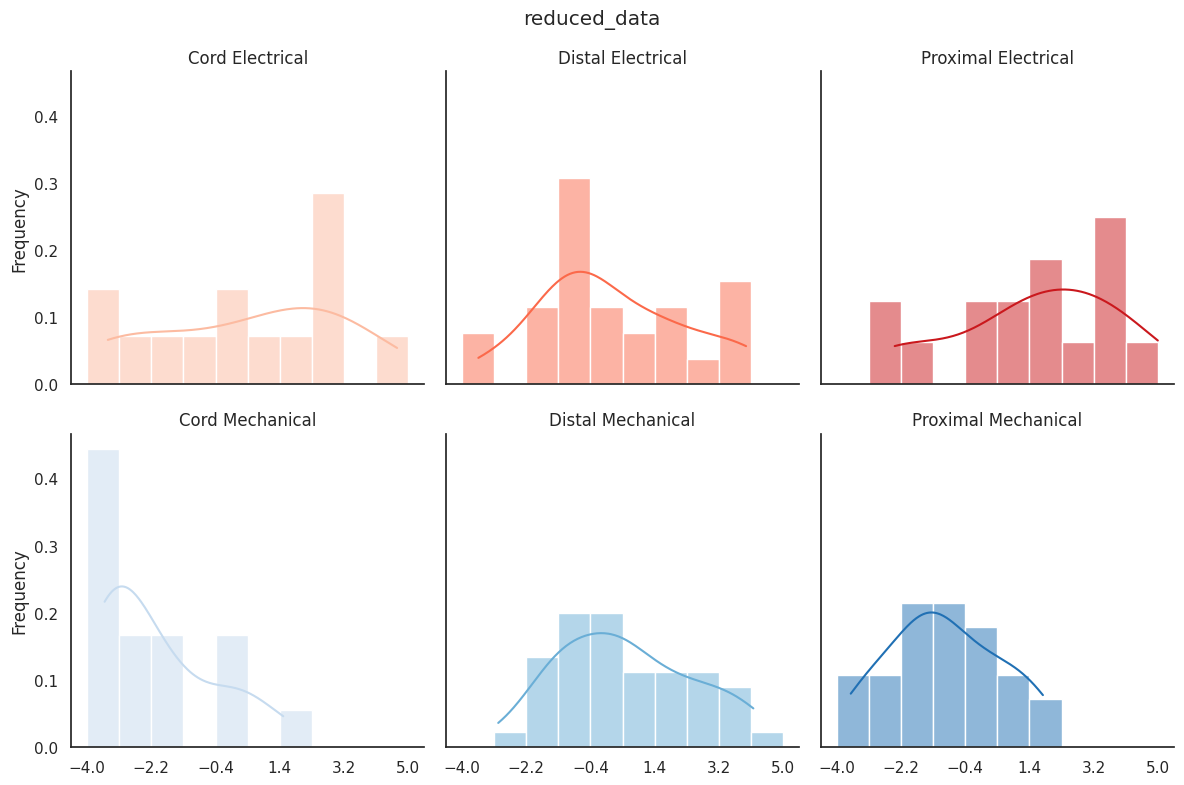

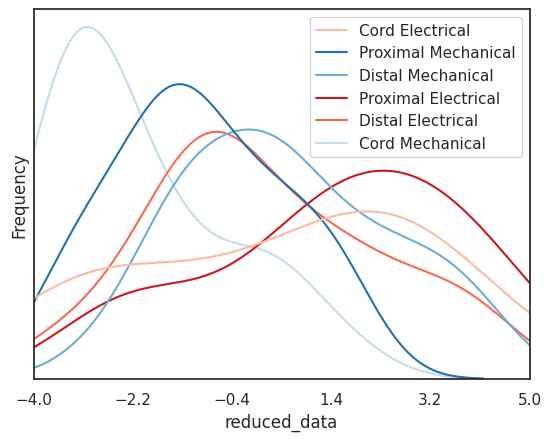

In [33]:
print(reduced_data[:, 0].shape)
df_new_features['reduced_data'] = reduced_data[:, 0]
visualize_hist_separate(df_new_features, 'reduced_data')

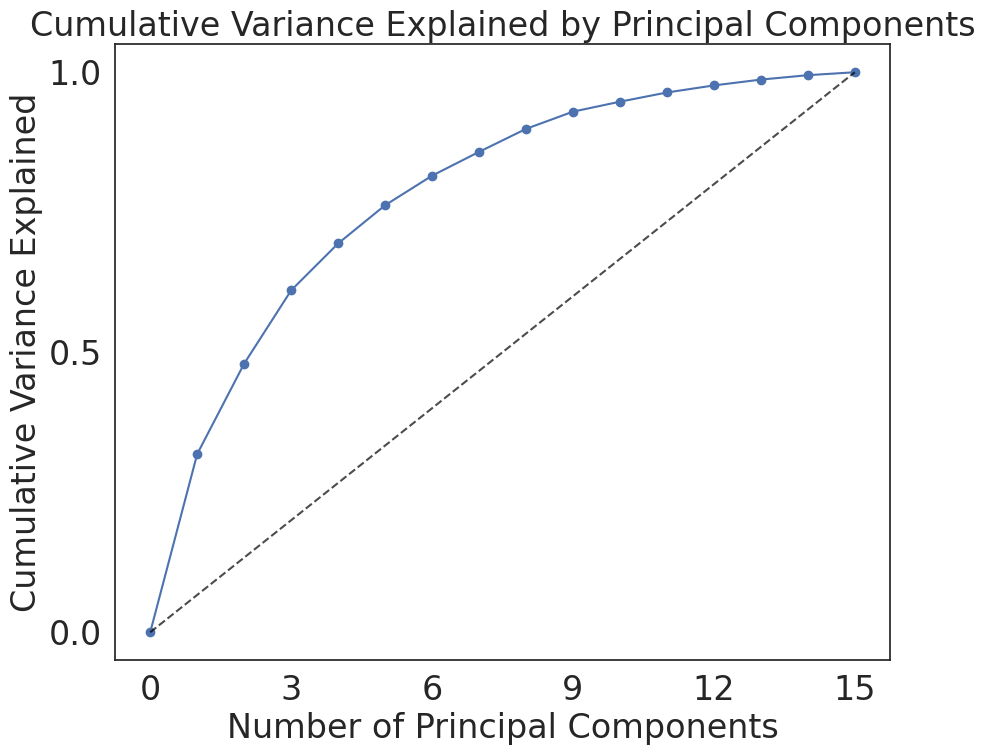

In [68]:
# Calculate cumulative variance explained

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance = np.insert(cumulative_variance, 0, 0)

# Plot the variance-explained graph
plt.figure(figsize=(10, 8))
plt.plot(range(len(cumulative_variance)), cumulative_variance, marker='o')
plt.plot([0, len(cumulative_variance)-1], [0, 1], linestyle='dashed', color='black', alpha=0.7)
# plt.xticks(np.arange(1, len(cumulative_variance) + 1))

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xticks(np.arange(0, 18, 3))
plt.yticks([0, 0.5, 1])
# plt.grid(True)
plt.savefig("cum_var_explained.svg")
plt.show()

In [144]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

In [132]:
import numpy as np
from sklearn.mixture import GaussianMixture

X = reduced_data
n_components_range = range(1, 11)

# Initialize empty lists to store BIC values
bic_values = []

# Fit GMM models for different numbers of components and calculate BIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_values.append(gmm.bic(X))

optimal_n_components_bic = np.argmin(bic_values) + 1

print("Optimal number of components (BIC):", optimal_n_components_bic)


Optimal number of components (BIC): 6


In [133]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

# Generate sample data for clustering
X = reduced_data
y_true = df_features['labels']['stim_class'].values.astype(int)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Perform Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

print("GMM:")
print("Silhouette Score:", silhouette_score(X, gmm_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, gmm_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, gmm_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, gmm_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, gmm_labels))

print()

# Evaluate clustering results using various metrics
print("K-means:")
print("Silhouette Score:", silhouette_score(X, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, kmeans_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, kmeans_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, kmeans_labels))


GMM:
Silhouette Score: 0.21359068799531442
Calinski-Harabasz Index: 36.41147496125993
Davies-Bouldin Index: 1.6568058907072094
Adjusted Rand Index: 0.0326058795154187
Normalized Mutual Information: 0.10969632445727025

K-means:
Silhouette Score: 0.19225440116737058
Calinski-Harabasz Index: 38.44774264913063
Davies-Bouldin Index: 1.729367898370537
Adjusted Rand Index: 0.05148099611301635
Normalized Mutual Information: 0.10069525555402875


In [153]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

data = reduced_data

NO_OF_CLUSTERS = 6
GMM = GaussianMixture(n_components = NO_OF_CLUSTERS, random_state=517).fit(data)
cluster = GMM.predict(data)
centroids = GMM.means_

In [154]:
def plot_ellipse(centroids, covariances, ax, color):
    covariance_matrix = covariances
    mean_x, mean_y = centroids

    # Step 1: Eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 2: Calculate the principal axes and angles
    principal_axes = eigenvectors.T
    angle = -np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    # Step 3: Choose confidence levels (e.g., 1, 2, and 3 standard deviations)
    confidence_levels = [1, 2, 3]

    # Step 4: Plot the ellipses

    for level in confidence_levels:
        width = 2 * level * np.sqrt(eigenvalues[0])
        height = 2 * level * np.sqrt(eigenvalues[1])
        ellipse = Ellipse(xy=(mean_x, mean_y), width=width, height=height,
         angle=np.degrees(angle), color=color)
        ellipse.set_alpha(0.2)  # Set the ellipse transparency
        ax.add_patch(ellipse)

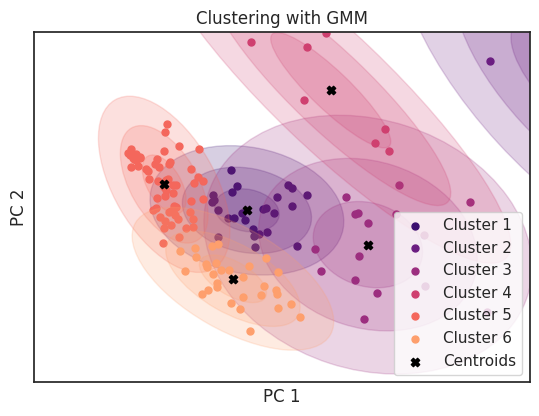

In [156]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=NO_OF_CLUSTERS))

for k in range(NO_OF_CLUSTERS):
    plot_ellipse(centroids[k], GMM.covariances_[k], ax, colors[k])
    plt.scatter(*data[cluster==k, :].T, s=25, color=colors[k], label=f'Cluster {k+1}')
    
plt.scatter(*centroids.T, marker='X', c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Clustering with GMM')
plt.legend()

In [ ]:
# Clustering - KMeans

from sklearn.cluster import KMeans

data = reduced_data

NO_OF_CLUSTERS = 3
# Create a KMeans instance with 3 clusters
kmeans = KMeans(n_clusters=NO_OF_CLUSTERS, random_state=42)

# Fit the KMeans model to the data and predict the cluster labels
cluster_labels = kmeans.fit_predict(data)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=3))

for c in range(NO_OF_CLUSTERS): 
    # Separate the data points by cluster
    cluster_data = data[cluster_labels == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {c+1}', color=colors[c])

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Clustering with K-Means')
plt.legend()
plt.show()

In [ ]:
# Clustering - AgglomerativeClustering

from sklearn.cluster import AgglomerativeClustering

data = reduced_data

NO_OF_CLUSTERS = 3
# Create a KMeans instance with 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=NO_OF_CLUSTERS)

# Fit the KMeans model to the data and predict the cluster labels
cluster_labels = agg_clustering.fit_predict(data)

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=3))

for c in range(NO_OF_CLUSTERS): 
    # Separate the data points by cluster
    cluster_data = data[cluster_labels == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {c+1}', color=colors[c])

# Plot the cluster centers
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Agglomerative Clustering')
plt.legend()
plt.show()

In [ ]:
# # Plot angles and p-likelihood

# N = 2
# X = df_features['features', 'angles'].values[N-1:N]
# y = df_features['labels'].iloc[N-1:N]

# movement_types = [
#     "No movement",
#     "Movement",
#     "Movement with arm curl"
# ]

# tx = driver.tx

# stim_class_list = driver.stim_class_list

# for i in range(1):
#     feature = X[i]
#     label = y.iloc[i]
#     print(df_features['metadata', 'filename'].iloc[i])
#     print(movement_types[label['move_class']],"|", stim_class_list[label['stim_class']])
#     for k in range(feature.shape[-1]):
#         plt.plot(tx, X[i][:, k], label=k)
#     plt.legend()
#     plt.show()

# X = df_features['features', 'p'].values[N-1:N]
# y = df_features['labels'].iloc[N-1:N]

# movement_types = [
#     "No movement",
#     "Movement",
#     "Movement with arm curl"
# ]

# tx = driver.tx

# stim_class_list = driver.stim_class_list

# for i in range(1):
#     feature = X[i]
#     label = y.iloc[i]
#     for k in range(feature.shape[-1]):
#         plt.plot(tx, X[i][:, k], label=k)
#     plt.legend()
#     plt.show()

In [ ]:
# %matplotlib tk

# import matplotlib.pyplot as plt
# import numpy as np

# WIDTH, HEIGHT = 640, 480

# R = 1
# df_ = df_features.iloc[R]
# print(df_['metadata', 'filename'])
# xy = df_['features', 'xy']
# x_coords, y_coords = xy[..., 0], xy[..., 1]

# y_coords = HEIGHT-y_coords

# num_points = xy.shape[1]  # Number of points to visualize

# # Create a figure and axis
# fig, ax = plt.subplots()

# colors = plt.cm.Blues(np.linspace(1, 0.2, num=num_points))

# # Create an empty scatter plot for each point
# scatters = [ax.scatter([], [], color=colors[i]) for i in range(num_points)]

# # Set up the axis limits
# ax.set_xlim(0, WIDTH)
# ax.set_ylim(0, HEIGHT)

# # Function to update the scatter plots
# def update_plots(i):
#     # Iterate through each point
#     for j in range(num_points):
#         # Get the current x and y coordinates for the point
#         x = x_coords[i, j]
#         y = y_coords[i, j]
        
#         # Update the scatter plot data for the point
#         scatters[j].set_offsets([(x, y)])
        
#     # Set the title to the current index
#     ax.set_title(f"Time Step: {driver.tx[i]:0.1f} s")
    
#     # Pause for a short duration (in seconds) to observe each point
#     plt.pause(1.5*1/30)

# # Iterate through each time step and update the plots
# for i in range(xy.shape[0]):
#     update_plots(i)

# # Show the final plots in a new window
# plt.show()


In [ ]:
df_features['labels', 'move_class'].value_counts()

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM


num_classes = 3

# Load and preprocess the data
X = np.stack(df_features['features', 'angles'].values, axis=-1)
X = X.reshape(-1, X.shape[-1]).T
y = df_features['labels', 'stim_class'].values.astype(int)

# Encode the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2]), activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=300, batch_size=4, verbose=0);

In [ ]:
%matplotlib inline
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Perform predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = [0, 1, 2]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Visualize the confusion matrix as a heatmap
first_words = [string.split()[0] for string in driver.stim_class_list]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=first_words, yticklabels=first_words)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Stimulation point of contact - using DLC')
plt.show()